ChEn-5310: Computational Continuum Transport Phenomena Spring 2021 UMass Lowell; Prof. V. F. de Almeida **25Jan21**

# 02. Fourier Basis Functions Least-Squares Residual
$  
  \newcommand{\Amtrx}{\boldsymbol{\mathsf{A}}}
  \newcommand{\Bmtrx}{\boldsymbol{\mathsf{B}}}
  \newcommand{\Mmtrx}{\boldsymbol{\mathsf{M}}}
  \newcommand{\Imtrx}{\boldsymbol{\mathsf{I}}}
  \newcommand{\Pmtrx}{\boldsymbol{\mathsf{P}}}
  \newcommand{\Lmtrx}{\boldsymbol{\mathsf{L}}}
  \newcommand{\Umtrx}{\boldsymbol{\mathsf{U}}}
  \newcommand{\Smtrx}{\boldsymbol{\mathsf{S}}}
  \newcommand{\xvec}{\boldsymbol{\mathsf{x}}}
  \newcommand{\avec}{\boldsymbol{\mathsf{a}}}
  \newcommand{\bvec}{\boldsymbol{\mathsf{b}}}
  \newcommand{\cvec}{\boldsymbol{\mathsf{c}}}
  \newcommand{\rvec}{\boldsymbol{\mathsf{r}}}
  \newcommand{\fvec}{\boldsymbol{\mathsf{f}}}
  \newcommand{\mvec}{\boldsymbol{\mathsf{m}}}
  \newcommand{\gvec}{\boldsymbol{\mathsf{g}}}
  \newcommand{\zerovec}{\boldsymbol{\mathsf{0}}}
  \newcommand{\norm}[1]{\bigl\lVert{#1}\bigr\rVert}
  \newcommand{\transpose}[1]{{#1}^\top}
  \DeclareMathOperator{\rank}{rank}
  \newcommand{\Reals}{\mathbb{R}}
  \newcommand{\thetavec}{\boldsymbol{\theta}}
$

---

## Table of Contents<a id="toc"></a>
* [Objectives](#obj)
* [Target Function](#f)
* [Collocation Points](#colpts)
* [Fourier Basis Functions w/ Least-Squares Residual](#fourier-lsq)
  - [Linear Combination of Non-Linear Basis Functions](#fourier-lincomb)
  - [Optimal Combination Coefficients](#fourier-optimal-coeff)
  - [Best Approximant Function](#fourier-approximant)
  - [Results](#fourier-res)
  - [Errors](#fourier-error)
  - [Residual](#fourier-residual)
* [Experiment #1](#ex1)
---

## [Objectives](#toc)<a id="obj"></a>

 + Practical use of Fourier basis functions to approximate a given function via the Galerkin Linear Least-Squares method.
 + Review [Introduction Notebook 01](https://nbviewer.jupyter.org/github/dpploy/engy-5310/blob/main/notebooks/01-introduction.ipynb)

## [Target Function](#toc)<a id="f"></a>

Given a *well-behaved* target function $f:[a,b]\rightarrow\Reals$. Compute an approximant $g:[a,b]\rightarrow\Reals$?

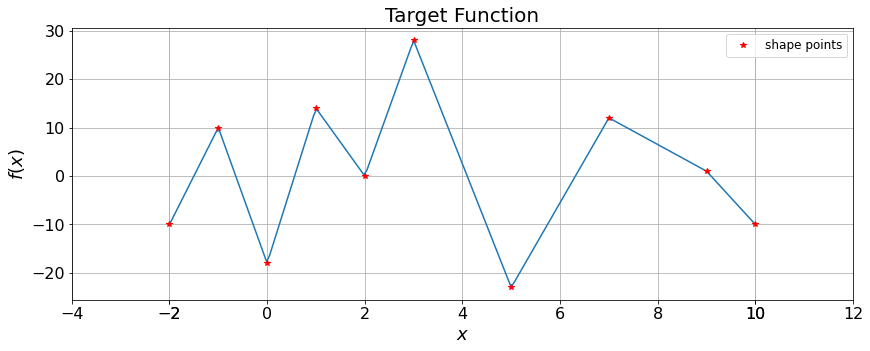

In [1]:
'''Generate the target function'''

try:    
    from engy_5310.toolkit import TargetFunction   
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'

shape_pts = [(-2,-10),(-1,10),(0,-18),(1,14),(2,0),(3,28),(5,-23),(7,12),(9,1),(10,-10)]

f = TargetFunction(shape_pts, type='linear')
  
f.plot(n_plot_pts=200, show_shape_pts=True, title='Target Function')

## [Collocation Points](#toc)<a id="colpts"></a>

Select *collocation* abscissa points and form the *set* $\{\tilde{x}_i \mid i=1,\ldots,m\}$ or vector $\tilde{\xvec}\in\Reals^m$.

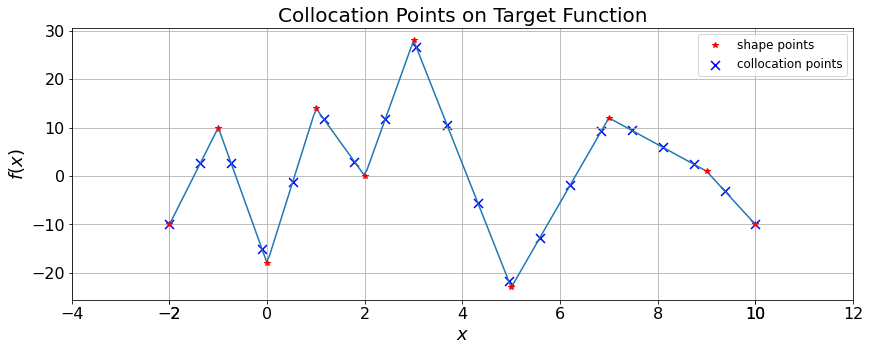

In [2]:
'''Collocation abscissa points'''
import numpy as np

x_min = shape_pts[0][0]
x_max = shape_pts[-1][0]

m = 20

x_tilde_pts = np.linspace(x_min, x_max, m)

f.plot(n_plot_pts=200, show_x_pts=x_tilde_pts, show_shape_pts=True, title='Collocation Points on Target Function')

## [Fourier Basis Functions w/ Least-Squares Residual](#toc)<a id="fourier-lsq"></a>

Using Fourier basis functions 

\begin{equation*}
   V := \{\cos, \,\sin\, \mid \, k=0,\ldots,N\},
\end{equation*}

and the collocation points $\tilde{\xvec}$, compute the best approximant function of $f:\Reals\rightarrow \Reals$ by minimizing the residual vector on the collocation points.

### [Linear Combination of Non-Linear Basis Functions](#toc)<a id="fourier-lincomb"></a>

Build the *basis functions evaluation matrix* $\Amtrx(\xvec)$ as a $m\times n$ real matrix, that is:

$\overset{(m \times n)}{\Amtrx(\xvec)} =  \begin{pmatrix}
1 & \cos(\kappa\,x_1) & \sin(\kappa\,x_1) & \cos(2\kappa\,x_1) & \sin(2\kappa\,x_1) & \ldots & \cos(N\kappa\,x_1) & \sin(N\kappa\,x_1)  \\
1 & \cos(\kappa\,x_2) & \sin(\kappa\,x_2) & \cos(2\kappa\,x_2) & \sin(2\kappa\,x_2) & \ldots & \cos(N\kappa\,x_2) & \sin(N\kappa\,x_2)  \\
\vdots  & \vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots \\
1 & \cos(\kappa\,x_m) & \sin(\kappa\,x_m) & \cos(2\kappa\,x_m) & \sin(2\kappa\,_m) & \ldots & \cos(N\kappa\,x_m) & \sin(N\kappa\,x_m)  \\
 \end{pmatrix}$,
 
and evaluate on the collocation points to create the *basis functions collocation matrix* $\tilde{\Amtrx} = \Amtrx(\tilde{\xvec})$.

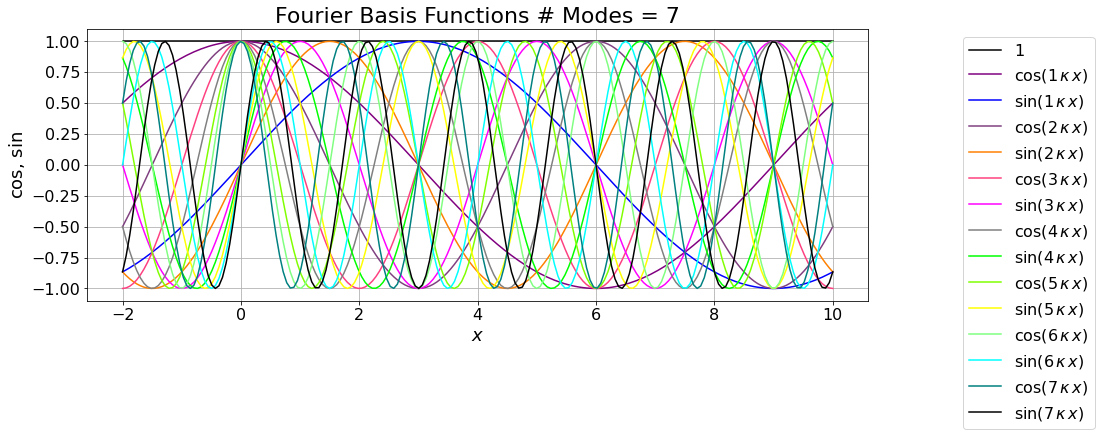

A is overdetermined.


In [3]:
'''Build the basis function evaluation matrix and target function vector at the collocation points'''

import math

wavelength = x_max - x_min
kappa = 2*math.pi/wavelength

N = 7 # number of pairs of sine/cosine

try:    
    from engy_5310.toolkit import FourierBasis  
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'

fb = FourierBasis(kappa, N, x_min, x_max)
fb.plot()

a_tilde_mtrx = fb.evaluate_matrix(x_tilde_pts)

f_tilde_vec = np.array(f.values(x_tilde_pts))

if a_tilde_mtrx.shape[0] > a_tilde_mtrx.shape[1]:
    print('A is overdetermined.')
elif a_tilde_mtrx.shape[0] < a_tilde_mtrx.shape[1]:
    print('A is underdetermined.')  
else:
    print('A is determined.')

### [Optimal Combination Coefficients](#toc)<a id="fourier-optimal-coeff"></a>

Compute the optimal coefficient vector by solving

\begin{equation*}
 \tilde{\Amtrx}^\top\tilde{\Amtrx}\,\tilde{\cvec}^* = \tilde{\Amtrx}^\top\,\tilde{\fvec} ,
\end{equation*}

which has a unique solution as long as $\tilde{\Amtrx}$ is full rank. Rank deficiency can be avoided by selecting proper basis functions, say orthogonal, and proper *collocation* abscissa points, say unique values (this is not a sufficient condition but a good start). Otherwise the least-squares method for rank-deficient problem must be employed and the shortest, minimal residual 2-norm computed. Therefore everything done to this point depends also on a choice of collocation points $\tilde{\xvec}$. To make this clear, the optimal coefficient vector is denoted $\tilde{\cvec}^*$.

In addition to $\hat{\cvec}^*$, compute the residual 2-norm

\begin{equation*}
 \norm{\tilde{\rvec}(\tilde{\cvec}^*)}_2 =  \norm{\tilde{\fvec} - \tilde{\Amtrx}\,\tilde{\cvec}^*}_2 ,
\end{equation*}

which is the quantity to be minimized.

In [4]:
'''Compute optimal coefficient vector'''

try:    
    from engy_5310.toolkit import solve 
    from engy_5310.toolkit import universal_solve
    from engy_5310.toolkit import matrix_rank
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'
    
if matrix_rank(a_tilde_mtrx) == min(a_tilde_mtrx.shape):
    print('A is full rank.')
    c_tilde_star_vec = solve(a_tilde_mtrx.transpose()@a_tilde_mtrx, a_tilde_mtrx.transpose()@f_tilde_vec)
else:
    print('A is rank deficient.')
    c_tilde_star_vec = universal_solve(a_tilde_mtrx.transpose()@a_tilde_mtrx, a_tilde_mtrx.transpose()@f_tilde_vec,
                                       pivot_tol=1e-6)
    
print('')
print('c_tilde_star_vec:\n')
for j,c in enumerate(c_tilde_star_vec):
    if j == 0:
        print('a_%2i = %10.3e'%(j,c))
    elif j%2 == 0:
        k = j/2
        print('b_%2i = %10.3e'%(k,c))
    else:
        k = (j+1)/2
        print('a_%2i = %10.3e'%(k,c))
        
print('')        
print('||r^*||_2 = %10.3e'%(np.linalg.norm(a_tilde_mtrx@c_tilde_star_vec-f_tilde_vec)))

A is full rank.

c_tilde_star_vec:

a_ 0 =  1.308e+00
a_ 1 =  1.207e+00
b_ 1 =  3.144e+00
a_ 2 = -7.236e+00
b_ 2 =  7.411e+00
a_ 3 =  8.691e-01
b_ 3 = -8.019e+00
a_ 4 =  3.383e-01
b_ 4 =  2.496e+00
a_ 5 = -4.959e+00
b_ 5 =  5.678e-01
a_ 6 = -4.488e+00
b_ 6 = -3.252e-02
a_ 7 = -2.424e+00
b_ 7 = -1.838e-01

||r^*||_2 =  4.576e+00


### [Best Approximant Function](#toc)<a id="fourier-approximant"></a>

The best approximant non-linear function $g_\text{best}:\Reals\rightarrow\Reals$, can be built as a vector-valued function for any set of points $\xvec\in\Reals^p$,

\begin{equation*}
 \boxed{\gvec_\text{best}(\xvec) = \Amtrx(\xvec)\,\tilde{\cvec}^*} ,
\end{equation*}

where $\Amtrx(\xvec)$ is the Fourier basis functions evaluation matrix for any given $\xvec$. Note that $\gvec$ is non-linear in $\xvec$. Also note that by design,
$\gvec_\text{best}(\tilde{\xvec}) = \Amtrx(\tilde{\xvec})\,\tilde{\cvec}^* = \tilde{\Amtrx}\,\tilde{\cvec}^* = \tilde{\gvec}(\tilde{\cvec}^*)$.

In [5]:
'''Build the best approximant function'''

def g_best_vec_func(x_pts):
    fb = FourierBasis(kappa, N, x_pts[0], x_pts[-1])
    a_mtrx = fb.evaluate_matrix(x_pts)
    return a_mtrx@c_tilde_star_vec

### [Results](#toc)<a id="fourier-res"></a>

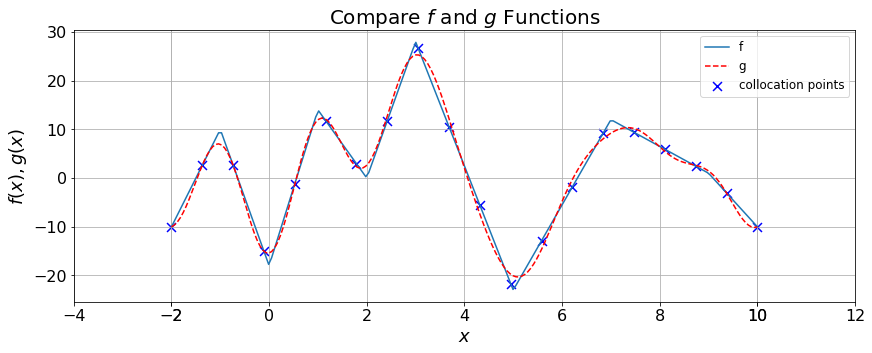

In [6]:
'''Plot comparison of f and g_best_vec'''

n_pts = max(2 * m, 200)
x_pts = np.linspace(x_min, x_max, n_pts)

g_vec = g_best_vec_func(x_pts)

f.plot(g=(x_pts,g_vec), n_plot_pts=n_pts, show_x_pts=x_tilde_pts, title='Compare $f$ and $g$ Functions')

### [Errors](#toc)<a id="fourier-error"></a>

Errors are instrumental to judge how good an approximation is. However the is no one absolute strategy to judge the quality of an approximation. Here we list a few possibilities.

**Local errors are too pessimistic.**

In [7]:
'''Local error depends on the number of sampling points'''

n_pts = max(2*m, 200)
x_pts = np.linspace(x_min, x_max, n_pts)

f_vec = f.values(x_pts)
g_vec = g_best_vec_func(x_pts)

shift = False

if shift:
    min_val = min(min(f_vec), min(g_vec))
    v_shift = min_val
    f_vec += abs(v_shift+1)
    g_vec += abs(v_shift+1)

print('mean local rel error [%] = ', np.mean(abs((g_vec-f_vec)/f_vec*100.0)))
print('std local rel error [%] = ', np.std(abs((g_vec-f_vec)/f_vec*100.0)))
print('max local rel error [%] = ', np.max(abs((g_vec-f_vec)/f_vec*100.0)))
print('min local rel error [%] = ', np.min(abs((g_vec-f_vec)/f_vec*100.0)))

mean local rel error [%] =  38.67314868430806
std local rel error [%] =  144.7993502839522
max local rel error [%] =  1365.5471324549071
min local rel error [%] =  0.05412880229422461


**Pitfall of area-based error.**

In [8]:
'''Area-based error'''

from scipy.integrate import quad

def f_integrand(x):
    return f.values(np.array([x]))
def g_integrand(x):
    return g_best_vec_func(np.array([x]))

f_integral = quad(f_integrand, x_min, x_max)
print('Area under f =', f_integral)

g_integral = quad(g_integrand, x_min, x_max)
print('Area under g =', g_integral)

print('rel error [%] = ', abs(g_integral[0]-f_integral[0])/f_integral[0]*100)

Area under f = (17.499999999999982, 1.942890293094022e-14)
Area under g = (15.699666542130839, 1.2788386148654407e-10)
rel error [%] =  10.28761975925226


**Relative $L_2$ norm error:**

\begin{equation*}
 \frac{ \norm{f-g_\text{best}}_{L_2(a,b)} }{ \norm{f}_{L_2(a,b)}} \, 100 .
\end{equation*}


In [9]:
'''L2 norm error'''

from scipy.integrate import quad
import math

print('||f||_L2 =', f.l2_norm[0])
#print('quadrature error =', error)

def g2_integrand(x):
    g_vec = g_best_vec_func(np.array([x]))
    return g_vec**2

print('')

g2_integral, error = quad(g2_integrand, x_min, x_max, limit=100)
print('||g||_L2 =', math.sqrt(g2_integral))
#print('quadrature error =', error)

def f_minus_g_2_integrand(x):
    f_x = f.values(np.array([x]))
    g_vec = g_best_vec_func(np.array([x]))
    return (f_x-g_vec)**2

print('')

f_minus_g_2_integral, error = quad(f_minus_g_2_integrand, x_min, x_max, limit=100)
print('||f-g||_L2 =', math.sqrt(f_minus_g_2_integral))
#print('quadrature error =', error)

print('')
print('Relative error [%] =', math.sqrt(f_minus_g_2_integral)/f.l2_norm[0]*100)

||f||_L2 = 37.09896674212549

||g||_L2 = 38.29467338755213

||f-g||_L2 = 4.212480587058301

Relative error [%] = 11.354711349076666


### [Residual](#toc)<a id="fourier-residual"></a>

**The residual vector mapping also produces information on the goodness of the approximation.**

An important property is to count how many positive and negative values in the residual exists. A good approximation will have an even distribution of positives and negatives, that is, the function is symmetric relative to the abscissa.

Positives at collocation pts =  10
Negatives at collocation pts =  10
Positives =  138
Negatives =  112


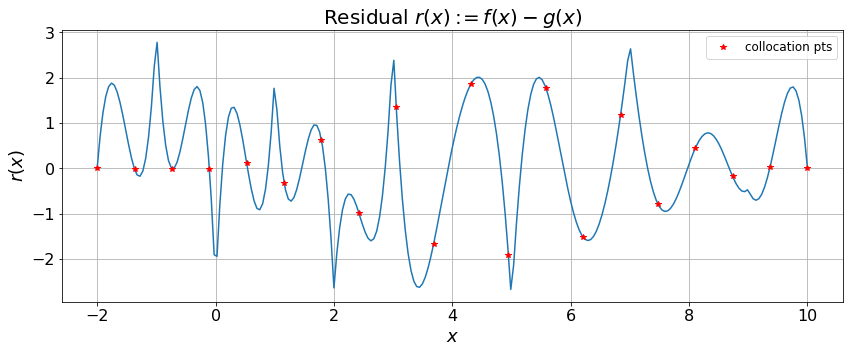

In [10]:
'''Residual of the best approximant'''

import matplotlib.pyplot as plt
%matplotlib inline

n_pts = max(3 * m, 250)
x_pts = np.linspace(x_min, x_max, n_pts)

residual = f.values(x_pts) - g_best_vec_func(x_pts)
residual_collocation_pts = f.values(x_tilde_pts) - g_best_vec_func(x_tilde_pts)
print('Positives at collocation pts = ', tuple([True for p in residual_collocation_pts if p>0]).count(True))
print('Negatives at collocation pts = ', tuple([True for p in residual_collocation_pts if p<0]).count(True))
print('Positives = ', tuple([True for p in residual if p>0]).count(True))
print('Negatives = ', tuple([True for p in residual if p<0]).count(True))
  
plt.figure(1, figsize=(14, 5))
plt.plot(x_pts, residual)
plt.plot(x_tilde_pts, f.values(x_tilde_pts)-g_best_vec_func(x_tilde_pts),'r*',label='collocation pts')
plt.title(r'Residual $r(x) :\!\!= f(x) - g(x)$', fontsize=20)
plt.ylabel(r'$r(x)$', fontsize=18)
plt.xlabel(r'$x$', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='best',fontsize=12)
plt.grid(True)
plt.show()

## [Experiments #1](#toc)<a id="ex1"></a>

Using the method of residual minimization of a linear combination of basis functions, compute an approximant to the given function $f:(a,b)\in\Reals\rightarrow \Reals$.

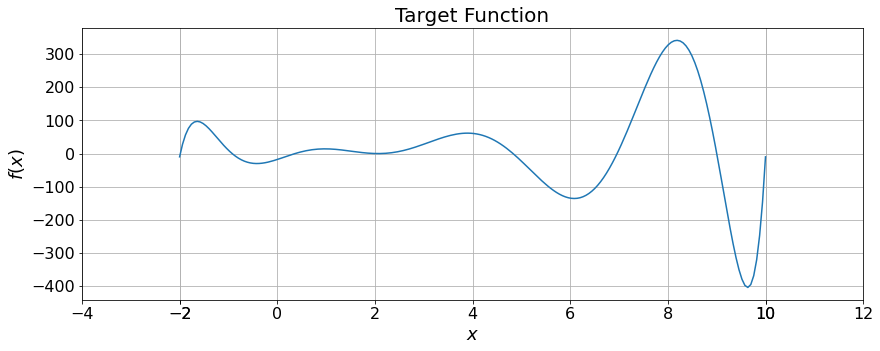

In [11]:
'''Consider another function'''

f = TargetFunction(shape_pts, type='lagrange')
  
f.plot(n_plot_pts=200, title='Target Function')

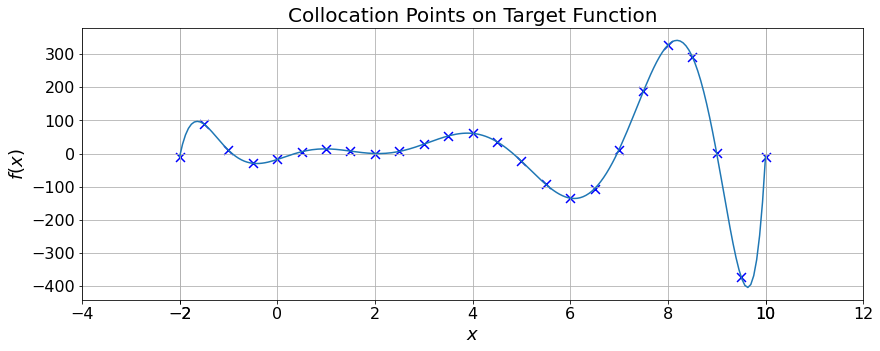

In [12]:
'''Collocation abscissa points'''
import numpy as np

x_min = shape_pts[0][0]
x_max = shape_pts[-1][0]

m = 25

x_tilde_pts = np.linspace(x_min, x_max, m)

f.plot(n_plot_pts=200, show_x_pts=x_tilde_pts, title='Collocation Points on Target Function')

In [13]:
'''Build the basis function evaluation matrix and target function vector at the collocation points'''

import math

wavelength = x_max - x_min
kappa = 2*math.pi/wavelength

N = 8 # number of pairs of sine/cosine

try:    
    from engy_5310.toolkit import FourierBasis  
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'

fb = FourierBasis(kappa, N, x_min, x_max)

a_tilde_mtrx = fb.evaluate_matrix(x_tilde_pts)
f_tilde_vec = np.array(f.values(x_tilde_pts))

if a_tilde_mtrx.shape[0] > a_tilde_mtrx.shape[1]:
    print('A is overdetermined.')
elif a_tilde_mtrx.shape[0] < a_tilde_mtrx.shape[1]:
    print('A is underdetermined.')  
else:
    print('A is determined.')

A is overdetermined.


In [14]:
'''Compute optimal coefficient vector'''

import numpy as np

try:    
    from engy_5310.toolkit import solve 
    from engy_5310.toolkit import universal_solve
    from engy_5310.toolkit import matrix_rank
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'

if matrix_rank(a_tilde_mtrx) == min(a_tilde_mtrx.shape):
    print('A is full rank.')
    #c_tilde_star_vec = solve(a_tilde_mtrx.transpose()@a_tilde_mtrx, a_tilde_mtrx.transpose()@f_tilde_vec)
    c_tilde_star_vec = np.linalg.solve(a_tilde_mtrx.transpose()@a_tilde_mtrx, a_tilde_mtrx.transpose()@f_tilde_vec)
else:
    print('A is rank deficient.')
    c_tilde_star_vec = universal_solve(a_tilde_mtrx.transpose()@a_tilde_mtrx, a_tilde_mtrx.transpose()@f_tilde_vec,
                                       pivot_tol=1e-7)

print('')
print('c_tilde_star_vec:\n')
for j,c in enumerate(c_tilde_star_vec):
    if j == 0:
        print('a_%2i = %10.3e'%(j,c))
    elif j%2 == 0:
        k = j/2
        print('b_%2i = %10.3e'%(k,c))
    else:
        k = (j+1)/2
        print('a_%2i = %10.3e'%(k,c))
        
print('')        
print('||r^*||_2 = %10.3e'%(np.linalg.norm(a_tilde_mtrx@c_tilde_star_vec-f_tilde_vec)))

A is full rank.

c_tilde_star_vec:

a_ 0 =  1.567e+01
a_ 1 = -1.170e+01
b_ 1 = -2.153e+01
a_ 2 = -4.635e+01
b_ 2 =  5.288e+01
a_ 3 =  9.972e+01
b_ 3 = -2.394e+01
a_ 4 = -6.469e+01
b_ 4 = -5.766e+01
a_ 5 = -5.389e+01
b_ 5 =  4.246e+01
a_ 6 =  1.802e+01
b_ 6 =  4.736e+01
a_ 7 =  3.795e+01
b_ 7 = -1.238e+00
a_ 8 =  8.774e+00
b_ 8 = -2.829e+01

||r^*||_2 =  1.291e+02


In [15]:
'''Build the best approximant function'''

def g_best_vec_func(x_pts):
    fb = FourierBasis(kappa, N, x_pts[0], x_pts[-1])
    a_mtrx = fb.evaluate_matrix(x_pts)
    return a_mtrx@c_tilde_star_vec

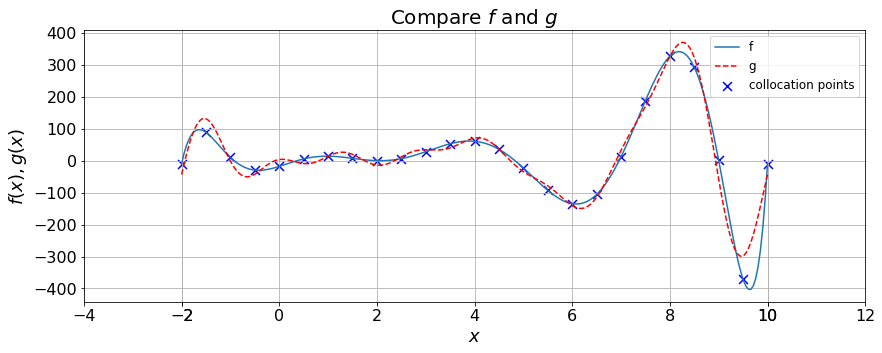

In [16]:
'''Plot comparison of f and g_vec'''

n_pts = max(2 * m, 250)
x_pts = np.linspace(x_min, x_max, n_pts)

g_vec = g_best_vec_func(x_pts)

f.plot(g=(x_pts,g_vec), n_plot_pts=n_pts, show_x_pts=x_tilde_pts, title='Compare $f$ and $g$')

In [17]:
'''Relative L2 norm error'''

from scipy.integrate import quad
import math

print('||f||_L2 =', f.l2_norm)

def g2_integrand(x):
    g_vec = g_best_vec_func(np.array([x]))
    return g_vec**2

print('')

g2_integral, error = quad(g2_integrand, x_min, x_max, limit=1000)
print('||g||_L2 =', math.sqrt(g2_integral))
print('quadrature error =', error)

x_ave = (x_min + x_max)/2
x_length = x_max - x_min

def f_minus_g_2_integrand(x):
    x_hat = 2*(x - x_ave)/x_length
    # single value call must be between -1 and 1
    f_x = f.values(np.array([x_hat]))
    g_vec = g_best_vec_func(np.array([x]))
    return (f_x-g_vec)**2

print('')

f_minus_g_2_integral, error = quad(f_minus_g_2_integrand, x_min, x_max, limit=1000)
print('||f-g||_L2 =', math.sqrt(f_minus_g_2_integral))
print('quadrature error =', error)

print('')
print('Relative error [%] =', math.sqrt(f_minus_g_2_integral)/f.l2_norm[0]*100)

||f||_L2 = (473.34854862851466, 2.4875529246317783e-09)

||g||_L2 = 449.3671888164555
quadrature error = 7.048919368202178e-07

||f-g||_L2 = 110.96882353335216
quadrature error = 1.8338437328679902e-06

Relative error [%] = 23.443364061192216


Positives at collocation pts =  14
Negatives at collocation pts =  11
Positives =  143
Negatives =  157


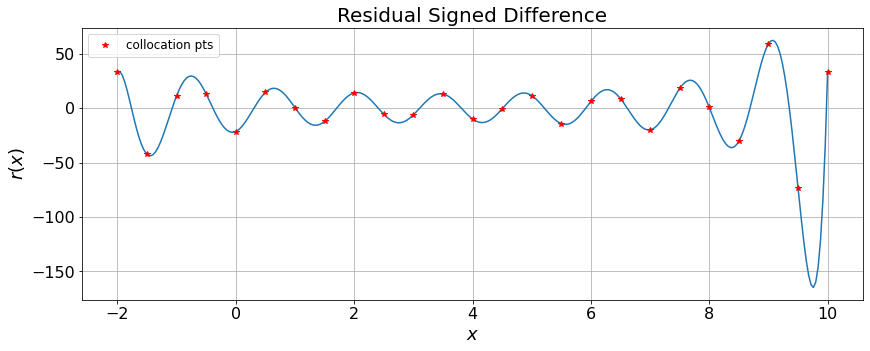

In [18]:
'''Residual of the best approximant'''

import matplotlib.pyplot as plt
%matplotlib inline

n_pts = max(4 * m, 300)
x_pts = np.linspace(x_min, x_max, n_pts)

residual = f.values(x_pts) - g_best_vec_func(x_pts)
residual_collocation_pts = f.values(x_tilde_pts) - g_best_vec_func(x_tilde_pts)
print('Positives at collocation pts = ', tuple([True for p in residual_collocation_pts if p>0]).count(True))
print('Negatives at collocation pts = ', tuple([True for p in residual_collocation_pts if p<0]).count(True))
print('Positives = ', tuple([True for p in residual if p>0]).count(True))
print('Negatives = ', tuple([True for p in residual if p<0]).count(True))
  
plt.figure(1, figsize=(14, 5))
plt.plot(x_pts, residual)
plt.plot(x_tilde_pts, f.values(x_tilde_pts)-g_best_vec_func(x_tilde_pts),'r*',label='collocation pts')
plt.title('Residual Signed Difference', fontsize=20)
plt.ylabel(r'$r(x)$', fontsize=18)
plt.xlabel(r'$x$', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='best',fontsize=12)
plt.grid(True)
plt.show()